In [1]:
import TensorFrost as tf
import numpy as np
import matplotlib.pyplot as plt
import time

tf.initialize(tf.cpu, "/O2 /fp:fast /openmp")

N = 256
M = 512

def WaveIteration(u, v, dt):
    i,j = u.indices
    laplacian = u[i-1, j] + u[i+1, j] + u[i, j-1] + u[i, j+1] - u[i,j] * 4.0
    force = laplacian - 0.1 * tf.sin(2.0*np.pi*u)
    v_new = v + dt*force
    u_new = u + dt*v_new
    return u_new, v_new

def WaveEq():
    u = tf.input([-1, -1], tf.float32)
    v = tf.input(u.shape, tf.float32)

    u,v = WaveIteration(u, v, 0.2)

    return [u, v]

test = tf.compile(WaveEq)


TensorFrost module loaded!
TensorProgram:
  Kernel count: 1
  Intermediate buffers: 4
  Lines of generated code: 285
  IR size: 146



In [2]:
print(test.list_operations())

List of operations:

[] int m0 = memory()
[] int m1 = memory()

[m0,m1] float m2 = memory(memory_type=input, )
[m0,m1] float m3 = memory(memory_type=input, )

[m0,m1] float m4 = memory(memory_type=output, )

[m0,m1] float m5 = memory(memory_type=output, )

[m0,m1] int v5_0 = dim_id(data=[0], cost=0.000000)
[m0,m1] int v5_1 = dim_id(data=[1], cost=0.000000)
[m0,m1] int v5_2 = dim_id(data=[0], cost=0.000000)
[m0,m1] int v5_3 = dim_id(data=[1], cost=0.000000)
[m0,m1] int v5_5 = sub(inputs=[v5_2,v5_4(1)], cost=1.000000)
[m0,m1] int v5_7 = add(inputs=[v5_2,v5_6(1)], cost=1.000000)
[] int v5_9 = sub(inputs=[m0,v5_8(1)], cost=2.000000)
[m0,m1] int v5_11 = clamp(inputs=[v5_5,v5_10(0),v5_9], cost=7.000000)
[m0,m1] int v5_12 = mul(inputs=[v5_11,m1], cost=9.000000)
[] int v5_14 = sub(inputs=[m1,v5_13(1)], cost=2.000000)
[m0,m1] int v5_16 = clamp(inputs=[v5_3,v5_15(0),v5_14], cost=6.000000)
[m0,m1] int v5_17 = add(inputs=[v5_12,v5_16], cost=16.000000)
[m0,m1] float v5_18 = load(memory=[m2], indice

In [3]:
#do a few steps and measure performance by timing every 100 steps
import time
import imageio
from IPython.display import Image
import os

start = time.time()

file_path = 'H:/TestVideos/wave.gif'

#remove file if it exists

if os.path.isfile(file_path):
    os.remove(file_path)

writer = imageio.get_writer(file_path, mode='I', fps=30, loop=0)

x = np.arange(M)
y = np.arange(N)
X,Y = np.meshgrid(x, y)
Anp = np.exp(-((X-M/2)**2 + (Y-N/2+50)**2)/(10**2))
Anp += np.exp(-((X-M/2-50)**2 + (Y-N/2-50)**2)/(10**2))
Bnp = np.zeros((N, M))

A = tf.tensor(Anp)
B = tf.tensor(Bnp)

print("Used memory: " + str(tf.used_memory()))

iters = 1000

for i in range(iters):
    A, B = test(A, B)
    if(i % 50 == 0):
        frame = A.numpy
        frame = np.clip(np.abs(3.0 * frame * 255), 0, 255).astype(np.uint8)
        writer.append_data(frame)
    if i % 100 == 99:
        print("Iterations per second: " + str(100/(time.time()-start)))
        start = time.time()


writer.close()

print("Used memory: " + str(tf.used_memory()))

Used memory: 262144
Iterations per second: 869.5651452798309
Iterations per second: 6249.614828721708
Iterations per second: 5555.81105783241
Iterations per second: 6249.987334038654
Iterations per second: 5882.366800835869
Iterations per second: 5263.209145323814
Iterations per second: 4347.735588933462
Iterations per second: 4761.547106837558
Iterations per second: 5000.362422508345
Iterations per second: 5491.1485539976175
Used memory: 262146


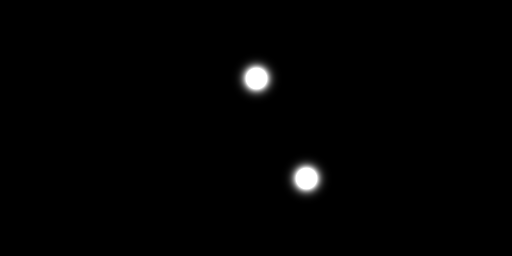

In [4]:
#display the gif
Image(filename=file_path)

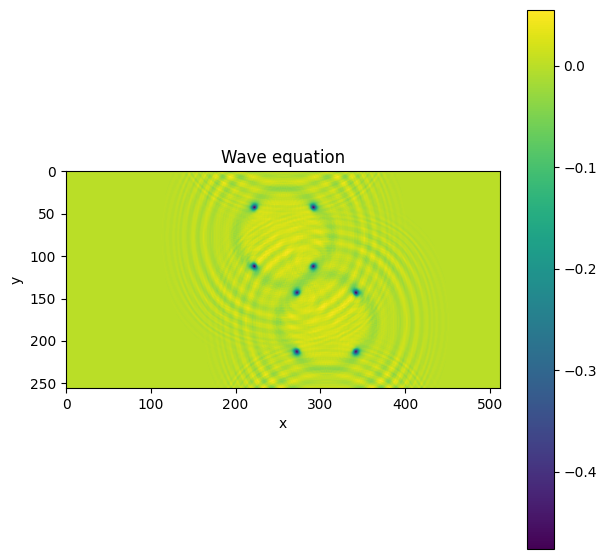

In [5]:
# Plot the results (with colorbar)
plt.figure(figsize=(7,7))
plt.imshow(A.numpy)
plt.colorbar()
plt.title("Wave equation")
plt.xlabel("x")
plt.ylabel("y")
plt.show()